# Week 02 · Image Enhancement — Point Processing
**Course:** Computer Vision (BCSE2022)  
**Instructor:** Bùi Huy Kiên  
**Prepared:** 2025-10-09 14:22

Notebook này gồm các ví dụ thực hành tương ứng phần *Point Processing*:  
1) Negative images  
2) Thresholding  
3) Logarithmic transformations  
4) Power-law (Gamma) — 4.1, 4.2, 4.3 (hiệu chỉnh màn hình)  
5) More Contrast Issues (Min-Max, Percentile Stretching)  
6) Piecewise Linear (6.1), Gray-level slicing (6.2)  
7) Bit-plane slicing (7.1) & Reconstruction (7.2)

**Hướng dẫn:**  
- Đặt các ảnh input theo tên ghi trong từng cell hoặc sửa đường dẫn cho phù hợp.  
- Mỗi cell hiển thị ảnh dùng `matplotlib` (không subplot — mỗi hình một plot).  
- Yêu cầu: `opencv-python`, `numpy`, `matplotlib`.


In [1]:

# Cài đặt & import (nếu cần)
# !pip install opencv-python numpy matplotlib

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def ensure_gray_uint8(img_path: str):
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Không tìm thấy ảnh: {img_path}")
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def to_float01(img_u8: np.ndarray):
    return img_u8.astype(np.float32) / 255.0

def to_uint8(img_f01: np.ndarray):
    return np.clip(np.round(img_f01 * 255.0), 0, 255).astype(np.uint8)

def show_image(img: np.ndarray, title: str):
    plt.figure(figsize=(5,5))
    if img.ndim == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()


## Ví dụ 1: Negative images

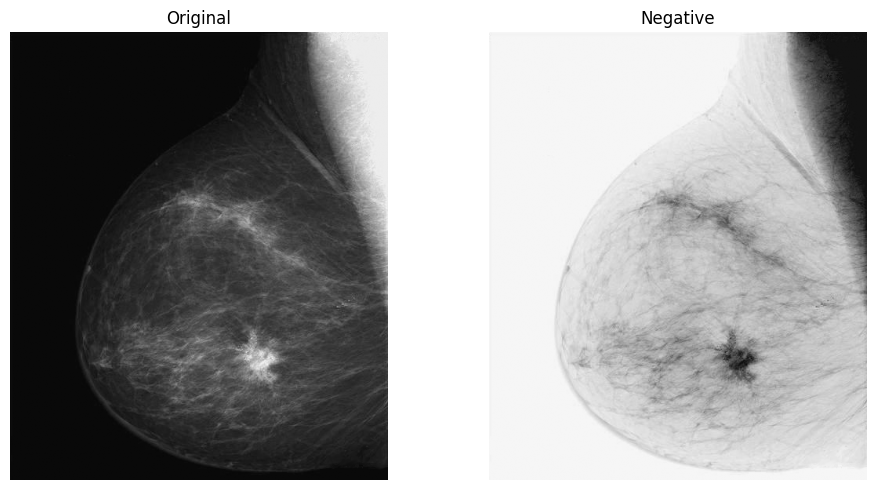

In [67]:
# Ví dụ 1: Negative images
# Input/Output yêu cầu: anh1_input.jpg -> anh1_output.jpg
try:
    src_path = "input/Fig0304(a)(breast_digital_Xray).tif"
    dst_path = "output/Fig0304(a)(breast_digital_Xray).jpg"
    img = ensure_gray_uint8(src_path)

    # Ảnh âm
    neg = 255 - img
    cv2.imwrite(dst_path, neg)

    # Hiển thị 2 ảnh cùng hàng
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img, cmap="gray")
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(neg, cmap="gray")
    axes[1].set_title("Negative")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Skip Example 1:", e)


## Ví dụ 2: Thresholding (Binary)

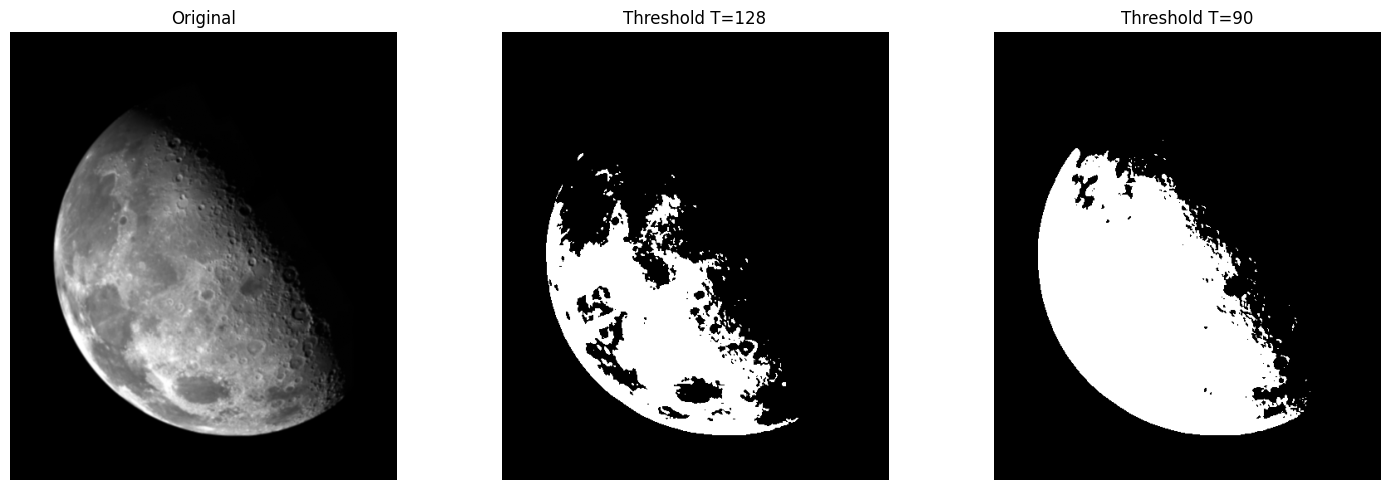

In [69]:
# Ví dụ 2: Thresholding (Binary)
try:
    path = "input/Fig0338(a)(blurry_moon).tif"
    img = ensure_gray_uint8(path)

    # Threshold ở 2 mức khác nhau
    _, th128 = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
    cv2.imwrite("output/Fig0338(a)(blurry_moon)_T128.jpg", th128)

    _, th90 = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
    cv2.imwrite("output/Fig0338(a)(blurry_moon)_T90.jpg", th90)

    # Vẽ ngang hàng 3 ảnh
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img, cmap="gray")
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(th128, cmap="gray")
    axes[1].set_title("Threshold T=128")
    axes[1].axis("off")

    axes[2].imshow(th90, cmap="gray")
    axes[2].set_title("Threshold T=90")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Skip Example 2:", e)


## Ví dụ 3: Logarithmic Transformations

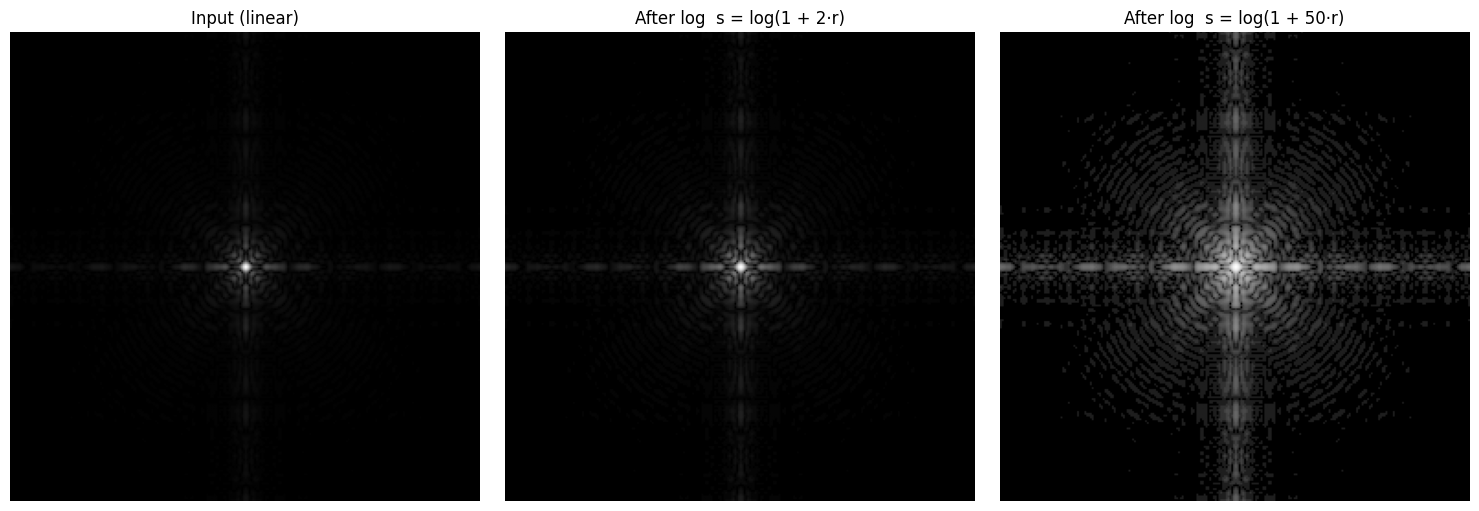

In [70]:
# Apply logarithmic transform to an existing FFT spectrum image (3-view row)
import cv2, numpy as np, matplotlib.pyplot as plt

# Đổi lại tên file nếu cần
spec_path = "input/Fig0305(a)(DFT_no_log).tif"   # ảnh FFT (grayscale 8-bit) đã có sẵn

# 1) Đọc ảnh FFT (8-bit) và chuẩn hóa về [0,1]
spec_u8 = cv2.imread(spec_path, cv2.IMREAD_GRAYSCALE)
if spec_u8 is None:
    raise FileNotFoundError(f"Không tìm thấy {spec_path}")
r = spec_u8.astype(np.float32) / 255.0

# 2) Log transform với c=2 và c=5
outputs = [("Input (linear)", spec_u8, None)]
for c in [2.0, 50.0]:
    s = np.log1p(c * r)
    s /= (s.max() + 1e-12)            # chuẩn hóa về [0,1] để hiển thị
    s_u8 = (s * 255).astype(np.uint8)
    cv2.imwrite(f"output/fft_spectrum_log_c{int(c)}.jpg", s_u8)
    outputs.append((f"After log  s = log(1 + {int(c)}·r)", s_u8, c))

# 3) Vẽ cùng 1 hàng
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, (title, img_u8, _) in zip(axes, outputs):
    ax.imshow(img_u8, cmap="gray")
    ax.set_title(title)
    ax.axis("off")
plt.tight_layout(); plt.show()


## Ví dụ 4.1: Power-Law (Gamma) — γ < 1 (làm sáng)

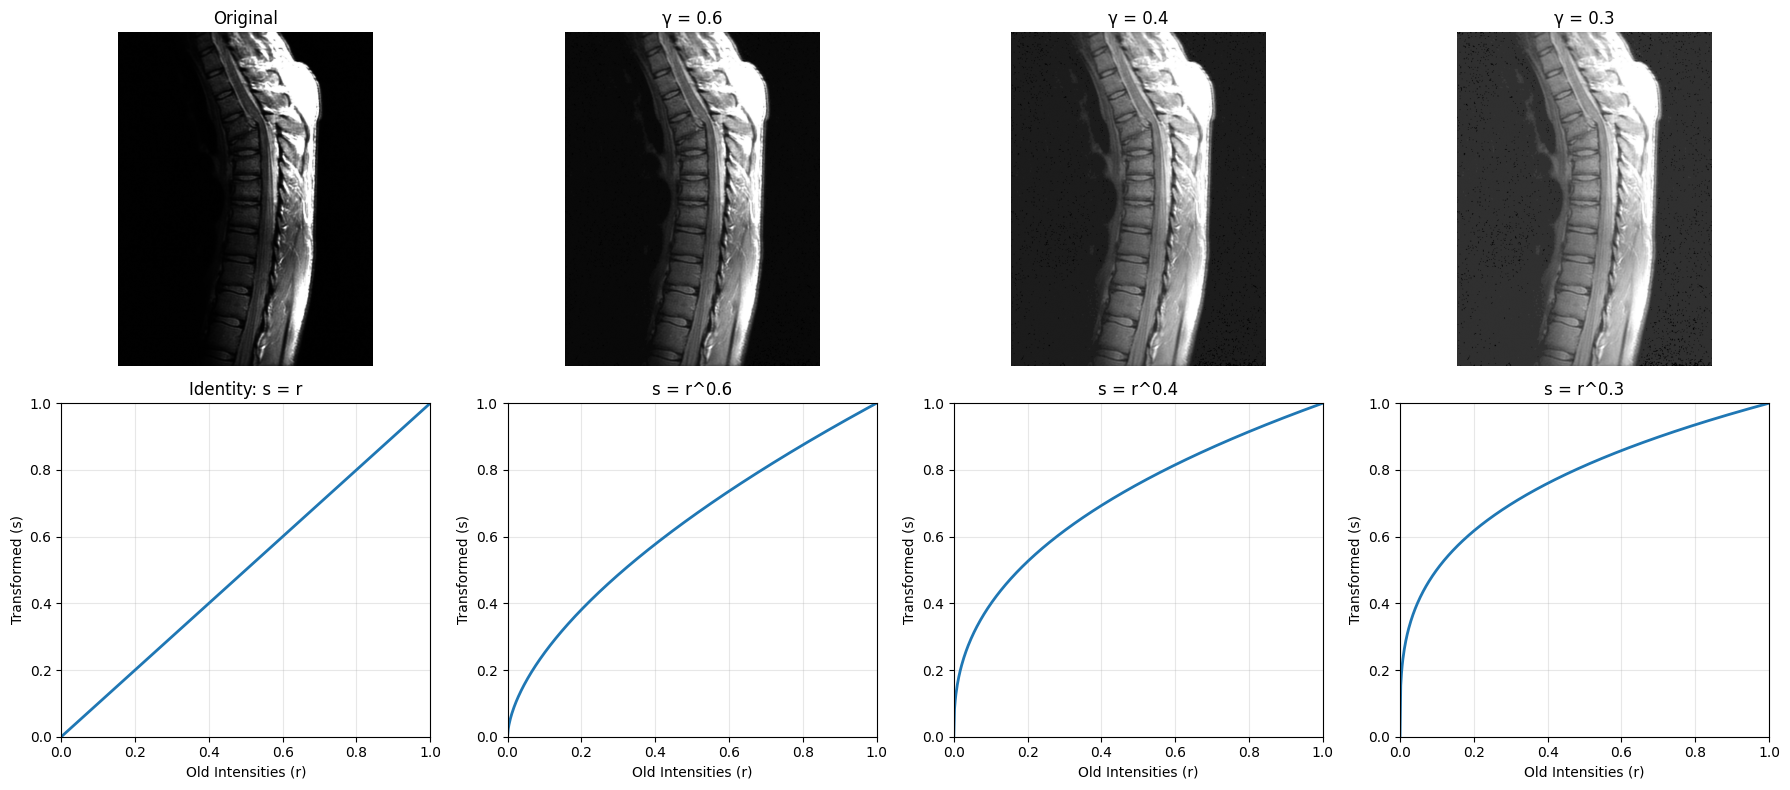

In [85]:
# Ví dụ 4.1: Power-Law (Gamma) — 2 hàng: ảnh + đồ thị s = r^γ
import os, cv2, numpy as np, matplotlib.pyplot as plt

try:
    path = "input/Fig0308(a)(fractured_spine).tif"
    os.makedirs("output", exist_ok=True)

    # --- Utils ngắn gọn (dùng nếu thầy chưa import từ trước) ---
    def ensure_gray_uint8(p):
        im = cv2.imread(p, cv2.IMREAD_UNCHANGED)
        if im is None:
            raise FileNotFoundError(p)
        if im.ndim == 3:
            im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        return np.clip(im, 0, 255).astype(np.uint8)

    def to_float01(u8): return u8.astype(np.float32) / 255.0
    def to_uint8(f):    return np.clip(np.round(f*255), 0, 255).astype(np.uint8)

    # --- Load & chuẩn hóa ---
    img = ensure_gray_uint8(path)
    r   = to_float01(img)
    gammas = [0.6, 0.4, 0.3]

    # --- Tính ảnh gamma ---
    outs = [img]
    titles_top = ["Original"]
    for g in gammas:
        s = np.power(np.clip(r, 0.0, 1.0), g)
        out = to_uint8(s)
        cv2.imwrite(f"output/gamma_case1_gamma{g}.jpg", out)
        outs.append(out)
        titles_top.append(f"γ = {g}")

    # --- Tạo đồ thị s = r^γ ---
    x = np.linspace(0, 1, 512, dtype=np.float32)
    curves = [x] + [np.power(x, g) for g in gammas]  # cột 1 là identity s=r
    titles_bot = ["Identity: s = r"] + [f"s = r^{g}" for g in gammas]

    # --- Vẽ 2 hàng x 4 cột ---
    fig, axes = plt.subplots(2, 4, figsize=(18, 8))

    # Hàng trên: ảnh
    for j, (im, ttl) in enumerate(zip(outs, titles_top)):
        axes[0, j].imshow(im, cmap="gray")
        axes[0, j].set_title(ttl)
        axes[0, j].axis("off")

    # Hàng dưới: đồ thị
    for j, (y, ttl) in enumerate(zip(curves, titles_bot)):
        ax = axes[1, j]
        ax.plot(x, y, linewidth=2)
        ax.set_xlim(0, 1); ax.set_ylim(0, 1)
        ax.set_xlabel("Old Intensities (r)")
        ax.set_ylabel("Transformed (s)")
        ax.grid(True, alpha=0.3)
        ax.set_title(ttl)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Skip Example 4.1:", e)


## Ví dụ 4.2: Power-Law (Gamma) — γ > 1 (làm tối)

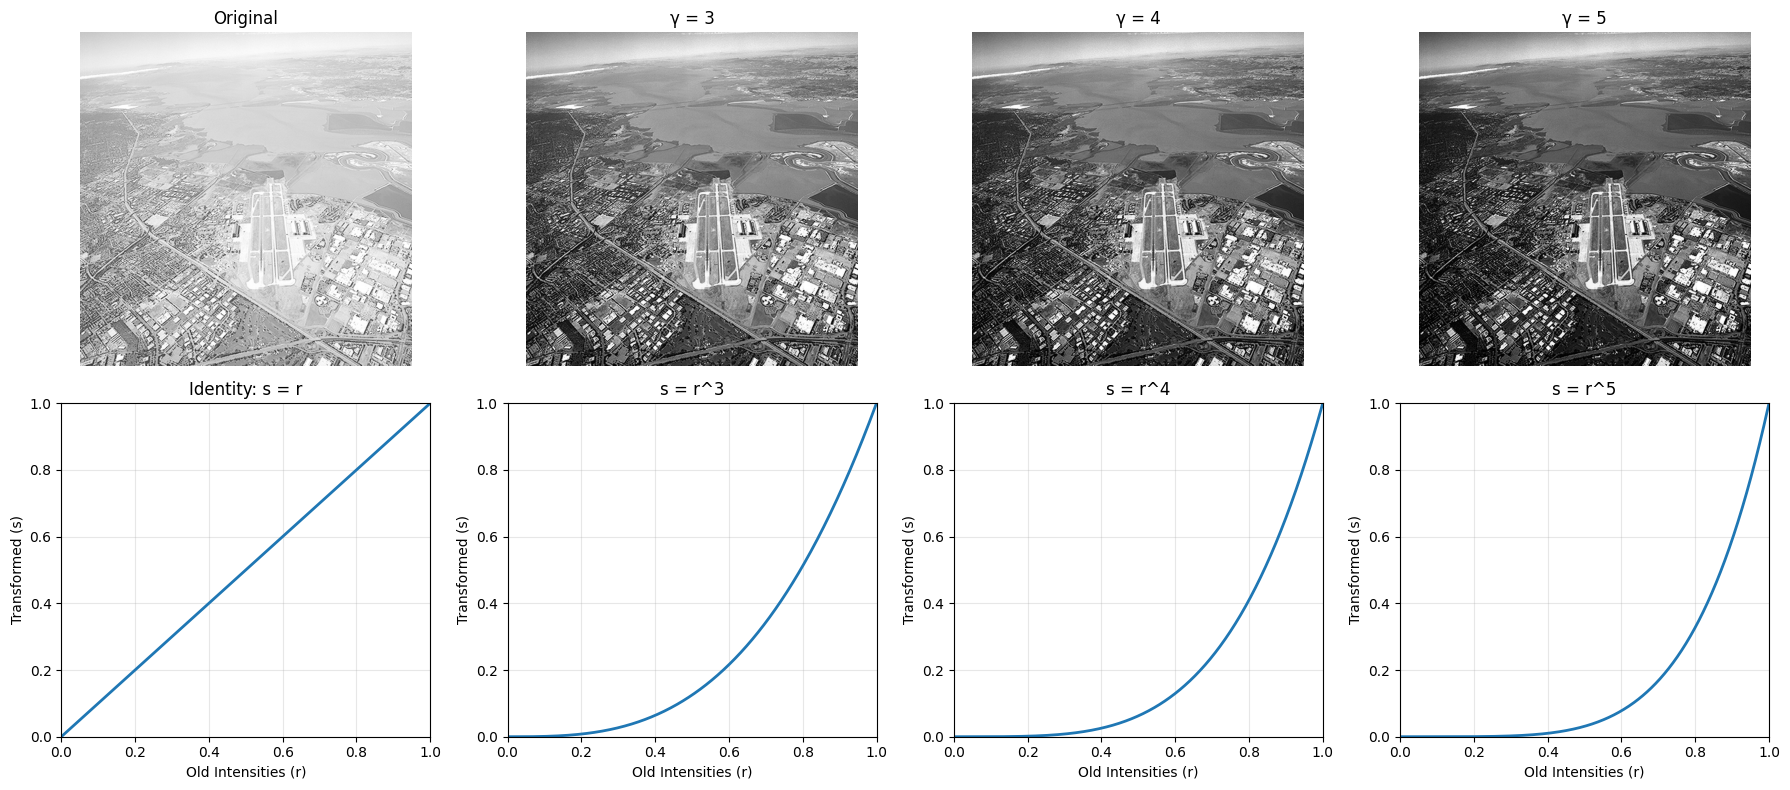

In [86]:
# Ví dụ 4.1: Power-Law (Gamma) — 2 hàng: ảnh + đồ thị s = r^γ
import os, cv2, numpy as np, matplotlib.pyplot as plt

try:
    path = "input/Fig0309(a)(washed_out_aerial_image).tif"
    os.makedirs("output", exist_ok=True)

    # --- Utils ngắn gọn (dùng nếu thầy chưa import từ trước) ---
    def ensure_gray_uint8(p):
        im = cv2.imread(p, cv2.IMREAD_UNCHANGED)
        if im is None:
            raise FileNotFoundError(p)
        if im.ndim == 3:
            im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        return np.clip(im, 0, 255).astype(np.uint8)

    def to_float01(u8): return u8.astype(np.float32) / 255.0
    def to_uint8(f):    return np.clip(np.round(f*255), 0, 255).astype(np.uint8)

    # --- Load & chuẩn hóa ---
    img = ensure_gray_uint8(path)
    r   = to_float01(img)
    gammas = [3, 4, 5]

    # --- Tính ảnh gamma ---
    outs = [img]
    titles_top = ["Original"]
    for g in gammas:
        s = np.power(np.clip(r, 0.0, 1.0), g)
        out = to_uint8(s)
        cv2.imwrite(f"output/gamma_case1_gamma{g}.jpg", out)
        outs.append(out)
        titles_top.append(f"γ = {g}")

    # --- Tạo đồ thị s = r^γ ---
    x = np.linspace(0, 1, 512, dtype=np.float32)
    curves = [x] + [np.power(x, g) for g in gammas]  # cột 1 là identity s=r
    titles_bot = ["Identity: s = r"] + [f"s = r^{g}" for g in gammas]

    # --- Vẽ 2 hàng x 4 cột ---
    fig, axes = plt.subplots(2, 4, figsize=(18, 8))

    # Hàng trên: ảnh
    for j, (im, ttl) in enumerate(zip(outs, titles_top)):
        axes[0, j].imshow(im, cmap="gray")
        axes[0, j].set_title(ttl)
        axes[0, j].axis("off")

    # Hàng dưới: đồ thị
    for j, (y, ttl) in enumerate(zip(curves, titles_bot)):
        ax = axes[1, j]
        ax.plot(x, y, linewidth=2)
        ax.set_xlim(0, 1); ax.set_ylim(0, 1)
        ax.set_xlabel("Old Intensities (r)")
        ax.set_ylabel("Transformed (s)")
        ax.grid(True, alpha=0.3)
        ax.set_title(ttl)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Skip Example 4.1:", e)


## Ví dụ 4.3: Power-Law (Gamma) — Gamma Correction

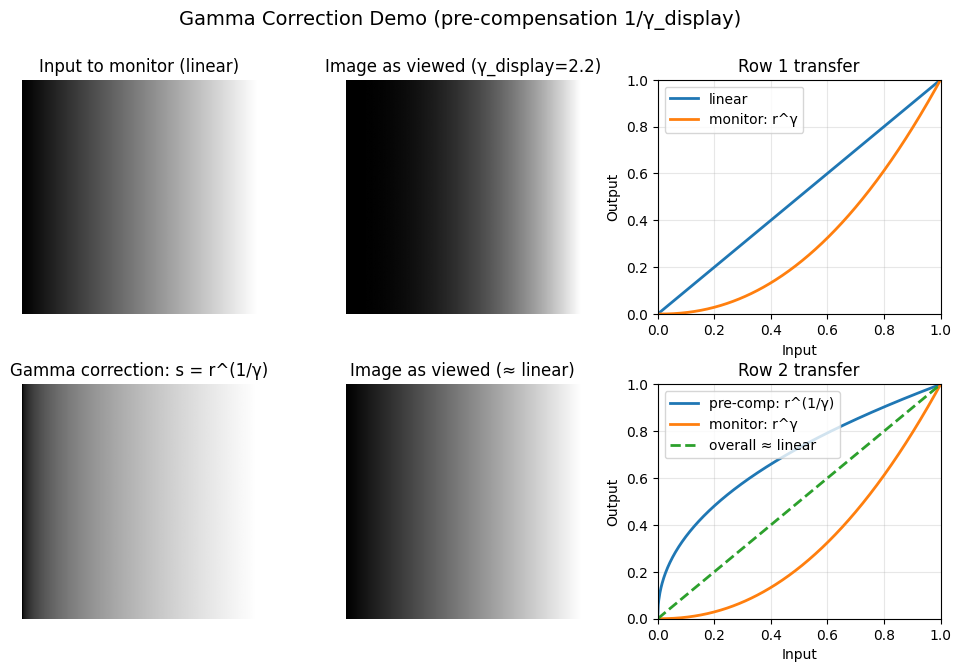

In [90]:
# Gamma correction demo: dùng chính ảnh ramp làm input
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ---- Helper: đọc ảnh xám uint8 ----
def ensure_gray_uint8(p):
    im = cv2.imread(p, cv2.IMREAD_UNCHANGED)
    if im is None:
        raise FileNotFoundError(p)
    if im.ndim == 3:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return np.clip(im, 0, 255).astype(np.uint8)

# ---- Đọc ảnh ramp làm input ----
src_path = "input/Fig0307(a)(intensity_ramp).tif"
img_u8   = ensure_gray_uint8(src_path)

# Chuẩn hóa về [0,1] để mô phỏng gamma
ramp = img_u8.astype(np.float32) / 255.0
H, W  = ramp.shape

# ---- Tham số màn hình ----
gamma_display = 2.2  # sRGB ~ 2.2

# ---- Hàng 1: KHÔNG hiệu chỉnh ----
input1 = ramp                          # tín hiệu nạp vào monitor
view1  = np.power(input1, gamma_display)  # monitor áp gamma -> ảnh nhìn thấy

# ---- Hàng 2: CÓ hiệu chỉnh (pre-compensation 1/gamma) ----
precomp = np.power(ramp, 1.0 / gamma_display)  # s = r^(1/γ)
view2   = np.power(precomp, gamma_display)     # qua monitor -> ≈ ramp

# ---- Vẽ ----
fig = plt.figure(figsize=(12, 7))
gs  = fig.add_gridspec(2, 3, width_ratios=[1,1,1.1], hspace=0.3, wspace=0.25)

# Hàng 1
ax11 = fig.add_subplot(gs[0,0]); ax11.imshow(input1, cmap='gray', vmin=0, vmax=1)
ax11.set_title("Input to monitor (linear)"); ax11.axis("off")

ax12 = fig.add_subplot(gs[0,1]); ax12.imshow(view1, cmap='gray', vmin=0, vmax=1)
ax12.set_title(f"Image as viewed (γ_display={gamma_display})"); ax12.axis("off")

ax13 = fig.add_subplot(gs[0,2])
x = np.linspace(0,1,512)
ax13.plot(x, x, label="linear", linewidth=2)
ax13.plot(x, x**gamma_display, label="monitor: r^γ", linewidth=2)
ax13.set_title("Row 1 transfer"); ax13.set_xlim(0,1); ax13.set_ylim(0,1)
ax13.set_xlabel("Input"); ax13.set_ylabel("Output"); ax13.grid(alpha=0.3); ax13.legend()

# Hàng 2
ax21 = fig.add_subplot(gs[1,0]); ax21.imshow(precomp, cmap='gray', vmin=0, vmax=1)
ax21.set_title("Gamma correction: s = r^(1/γ)"); ax21.axis("off")

ax22 = fig.add_subplot(gs[1,1]); ax22.imshow(view2, cmap='gray', vmin=0, vmax=1)
ax22.set_title("Image as viewed (≈ linear)"); ax22.axis("off")

ax23 = fig.add_subplot(gs[1,2])
ax23.plot(x, x**(1.0/gamma_display), label="pre-comp: r^(1/γ)", linewidth=2)
ax23.plot(x, x**gamma_display,       label="monitor: r^γ", linewidth=2)
ax23.plot(x, x, '--', label="overall ≈ linear", linewidth=2)
ax23.set_title("Row 2 transfer"); ax23.set_xlim(0,1); ax23.set_ylim(0,1)
ax23.set_xlabel("Input"); ax23.set_ylabel("Output"); ax23.grid(alpha=0.3); ax23.legend()

plt.suptitle("Gamma Correction Demo (pre-compensation 1/γ_display)", fontsize=14)
plt.show()


## Ví dụ 5: More Contrast Issues

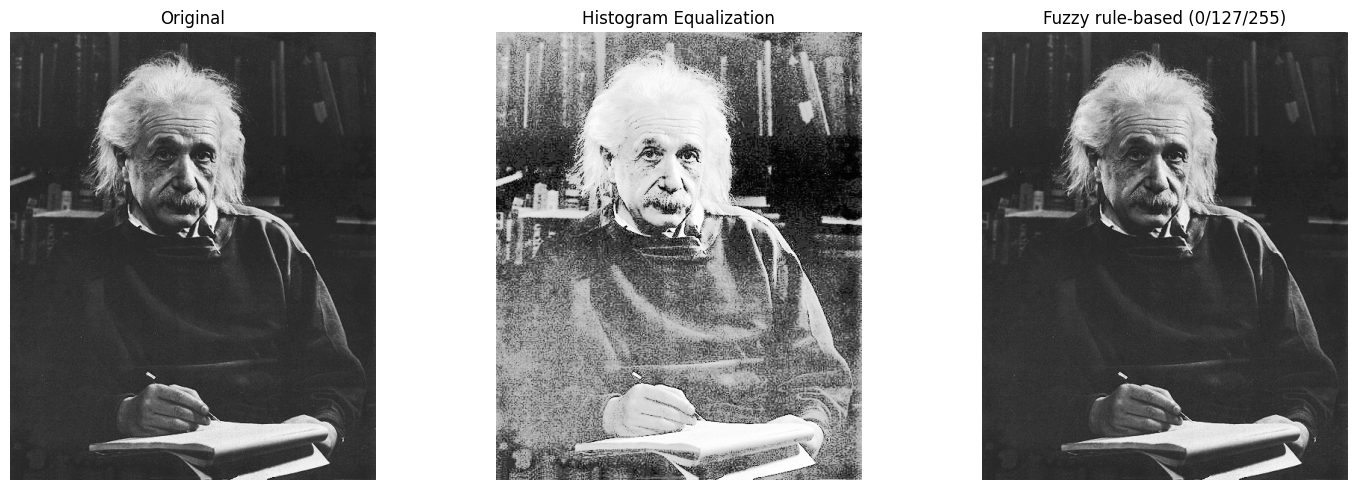

In [93]:
import cv2, numpy as np, matplotlib.pyplot as plt

# --- Helpers ---
def ensure_gray_uint8(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(path)
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.clip(img, 0, 255).astype(np.uint8)

def tri(x, a, b, c):
    x = x.astype(np.float32)
    mu = np.zeros_like(x, dtype=np.float32)
    rising  = (a < x) & (x <= b) & (b > a)
    mu[rising]  = (x[rising] - a) / (b - a + 1e-12)
    falling = (b < x) & (x < c) & (c > b)
    mu[falling] = (c - x[falling]) / (c - b + 1e-12)
    mu[x == b] = 1.0
    return np.clip(mu, 0, 1)

# --- Load image (low-contrast Einstein / ảnh của bạn) ---
img = ensure_gray_uint8("input/Fig0354(a)(einstein_orig).tif")  # đổi path nếu cần

# (a) Original
orig = img

# (b) Histogram Equalization
he = cv2.equalizeHist(img)

# (c) Fuzzy rule-based (singletons: 0, 127, 255)
r = img.astype(np.uint16)
mu_L = tri(r,   0,   0, 127)
mu_M = tri(r,   0, 127, 255)
mu_H = tri(r, 127, 255, 255)
vL, vM, vH = 0.0, 127.0, 255.0
den = (mu_L + mu_M + mu_H) + 1e-6
s  = (mu_L*vL + mu_M*vM + mu_H*vH) / den
fuzzy = np.clip(np.round(s), 0, 255).astype(np.uint8)

# --- Show: Original + HE + Fuzzy (1 hàng) ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(orig,  cmap="gray"); axes[0].set_title("Original"); axes[0].axis("off")
axes[1].imshow(he,    cmap="gray"); axes[1].set_title("Histogram Equalization"); axes[1].axis("off")
axes[2].imshow(fuzzy, cmap="gray"); axes[2].set_title("Fuzzy rule-based (0/127/255)"); axes[2].axis("off")
plt.tight_layout(); plt.show()


## Ví dụ 6.1: Piecewise Linear Transformation (2 điểm)
- Contrast stretching (piecewise linear): kéo giãn dải mức xám để tăng tương phản, làm chi tiết hạt phấn nổi rõ hơn.
- Thresholding: nhị phân hóa để tách hạt phấn khỏi nền sau khi đã kéo giãn tương phản.

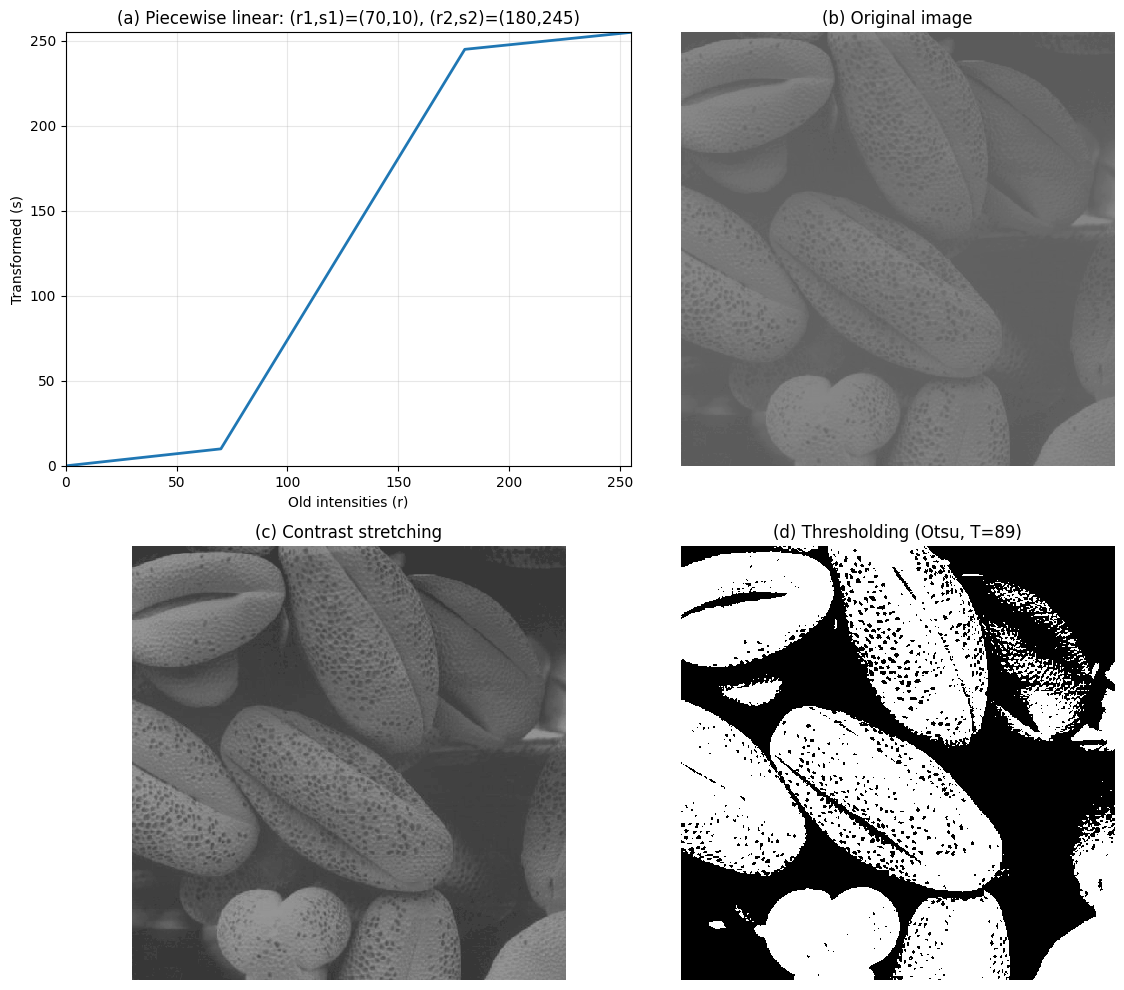

In [96]:
# FIGURE 3.10 — Piecewise Linear Transformation: Contrast Stretching + Thresholding
import cv2, numpy as np, matplotlib.pyplot as plt, os

def ensure_gray_uint8(p):
    img = cv2.imread(p, cv2.IMREAD_UNCHANGED)
    if img is None: raise FileNotFoundError(p)
    if img.ndim == 3: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.clip(img, 0, 255).astype(np.uint8)

def piecewise_linear(img_u8, r1, s1, r2, s2):
    x = img_u8.astype(np.float32)
    r1 = max(1, min(254, r1)); r2 = max(r1+1, min(255, r2))
    s1 = np.clip(s1, 0, 255);  s2 = np.clip(s2, 0, 255)
    y = np.zeros_like(x, dtype=np.float32)
    idx1 = x <= r1;                 y[idx1] = (s1 / r1) * x[idx1]
    idx2 = (x > r1) & (x <= r2);    y[idx2] = s1 + (s2 - s1) * (x[idx2] - r1) / (r2 - r1)
    idx3 = x > r2;                  y[idx3] = s2 + (255 - s2) * (x[idx3] - r2) / (255 - r2)
    return np.clip(np.round(y), 0, 255).astype(np.uint8)

def draw_piecewise_curve(r1, s1, r2, s2):
    xs = np.arange(256, dtype=np.float32); ys = np.zeros_like(xs)
    for i, x in enumerate(xs):
        if x <= r1:   ys[i] = (s1 / r1) * x
        elif x <= r2: ys[i] = s1 + (s2 - s1) * (x - r1) / (r2 - r1)
        else:         ys[i] = s2 + (255 - s2) * (x - r2) / (255 - r2)
    return xs, np.clip(ys, 0, 255)

# Input
img_path = "input/Fig0310(b)(washed_out_pollen_image).tif"
os.makedirs("output", exist_ok=True)
img = ensure_gray_uint8(img_path)

# Params (chỉnh theo histogram)
r1, s1 = 70, 10
r2, s2 = 180, 245
stretched = piecewise_linear(img, r1, s1, r2, s2)

# Threshold (Otsu)
T, th = cv2.threshold(stretched, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Plot (a)-(d)
xs, ys = draw_piecewise_curve(r1, s1, r2, s2)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# (a) Hàm biến đổi
ax = axes[0,0]
ax.plot(xs, ys, linewidth=2)
ax.set_title(f"(a) Piecewise linear: (r1,s1)=({r1},{s1}), (r2,s2)=({r2},{s2})")
ax.set_xlabel("Old intensities (r)"); ax.set_ylabel("Transformed (s)")
ax.set_xlim(0,255); ax.set_ylim(0,255); ax.grid(alpha=0.3)

# ---- Quan trọng: cố định thang sáng vmin=0, vmax=255 ----
# (b) Ảnh gốc (rất mờ) — hiển thị đúng, KHÔNG auto-contrast
axes[0,1].imshow(img, cmap="gray", vmin=0, vmax=255, interpolation="nearest")
axes[0,1].set_title("(b) Original image")
axes[0,1].axis("off")

# (c) Ảnh sau contrast stretching
axes[1,0].imshow(stretched, cmap="gray", vmin=0, vmax=255, interpolation="nearest")
axes[1,0].set_title("(c) Contrast stretching")
axes[1,0].axis("off")

# (d) Ảnh thresholding (Otsu)
axes[1,1].imshow(th, cmap="gray", vmin=0, vmax=255, interpolation="nearest")
axes[1,1].set_title(f"(d) Thresholding (Otsu, T={T:.0f})")
axes[1,1].axis("off")

plt.tight_layout(); plt.show()

## Ví dụ 6.2: Gray-level slicing (intensity level slicing / band-pass thresholding)

Band [A,B]=[142,230] from percentiles [85%,99%]


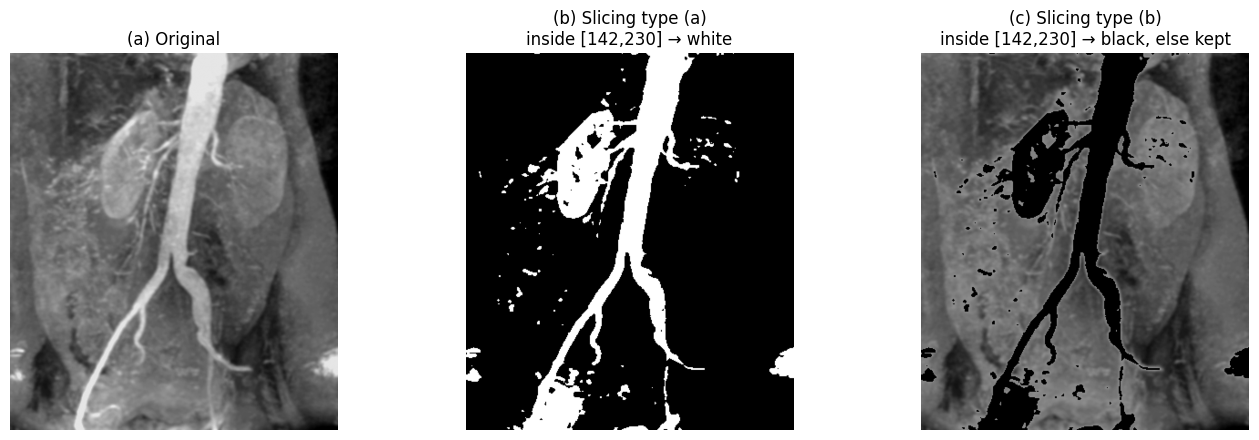

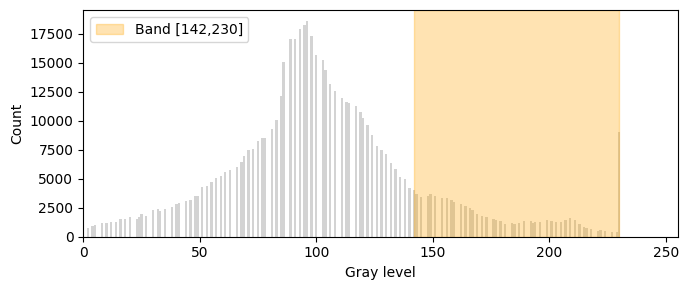

True

In [101]:
# Intensity-level slicing: two variants like Fig. 3.11/3.12
import cv2, numpy as np, matplotlib.pyplot as plt, os

def ensure_gray_uint8(p):
    im = cv2.imread(p, cv2.IMREAD_UNCHANGED)
    if im is None: raise FileNotFoundError(p)
    if im.ndim == 3: im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return np.clip(im, 0, 255).astype(np.uint8)

# ---- Input ----
img_path = "input/Fig0312(a)(kidney).tif"   # đổi thành ảnh của bạn (ảnh xám)
os.makedirs("output", exist_ok=True)
img = ensure_gray_uint8(img_path)

# ---- Chọn dải cần làm nổi bật (A..B) ----
# gợi ý: dùng percentile để ước lượng nhanh
pA, pB = 85, 99          # dải sáng ở cuối thang xám (ví dụ cho mạch sáng)
A, B = np.percentile(img, [pA, pB]).astype(int)
print(f"Band [A,B]=[{A},{B}] from percentiles [{pA}%,{pB}%]")

# ---- Variant (a): inside band -> WHITE, outside -> BLACK (binary-like) ----
mask = (img >= A) & (img <= B)
s_a = np.zeros_like(img, dtype=np.uint8)
s_a[mask] = 255

# ---- Variant (b): keep outside, darken (or mark) the selected band ----
s_b = img.copy()
# đặt dải chọn về đen; có thể đổi thành 200 để “white band” nếu muốn.
s_b[mask] = 0

# ---- Show results (fix vmin/vmax để không auto-contrast) ----
fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))
axes[0].imshow(img, cmap="gray", vmin=0, vmax=255); axes[0].set_title("(a) Original"); axes[0].axis("off")
axes[1].imshow(s_a, cmap="gray", vmin=0, vmax=255); axes[1].set_title(f"(b) Slicing type (a)\ninside [{A},{B}] → white"); axes[1].axis("off")
axes[2].imshow(s_b, cmap="gray", vmin=0, vmax=255); axes[2].set_title(f"(c) Slicing type (b)\ninside [{A},{B}] → black, else kept"); axes[2].axis("off")
plt.tight_layout(); plt.show()

# ---- (Optional) xem histogram + band ----
hist, bins = np.histogram(img.ravel(), bins=256, range=(0,256))
plt.figure(figsize=(7,3))
plt.bar(np.arange(256), hist, width=1.0, color="lightgray", edgecolor="none")
plt.axvspan(A, B, color="orange", alpha=0.3, label=f"Band [{A},{B}]")
plt.xlim(0,255); plt.xlabel("Gray level"); plt.ylabel("Count"); plt.legend(); plt.tight_layout(); plt.show()

# ---- Save outputs ----
cv2.imwrite("output/slicing_type_a_whiteband.png", s_a)
cv2.imwrite("output/slicing_type_b_keepoutside.png", s_b)


## Ví dụ 7.1: Bit-plane slicing (b0..b7)

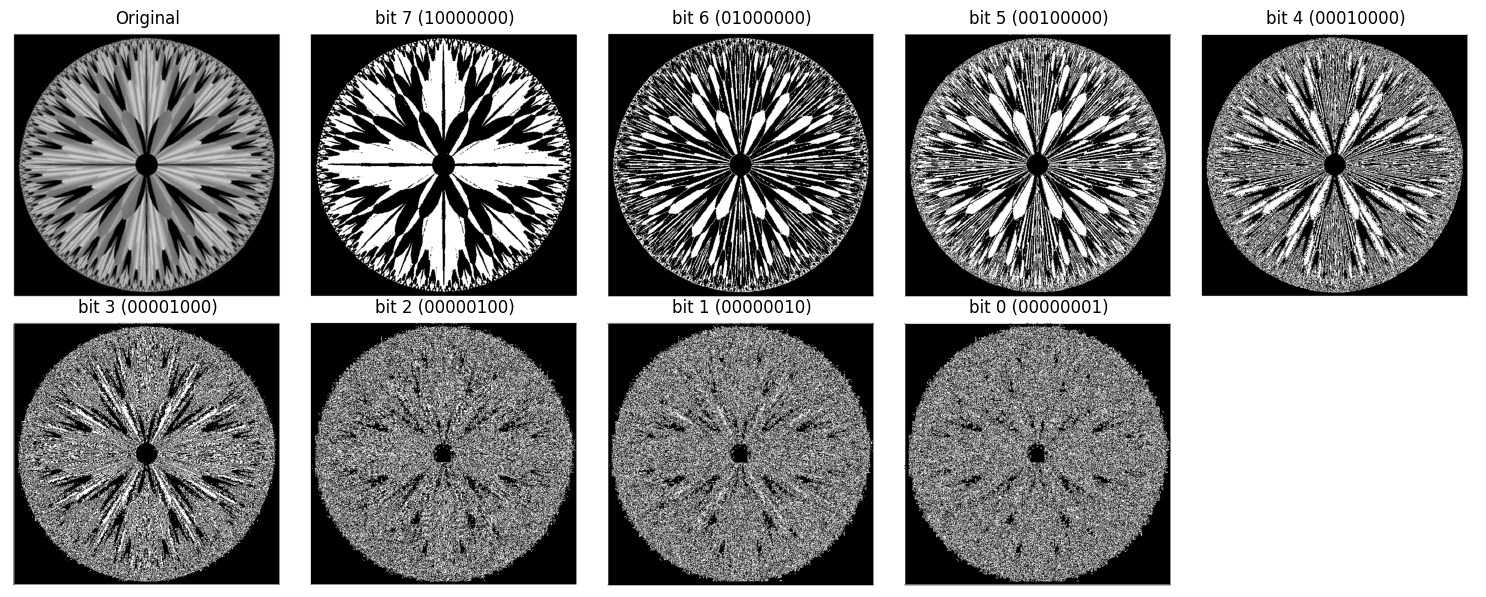

In [103]:
# Bit-Plane Slicing: 10000000 → 00000001
import cv2, numpy as np, matplotlib.pyplot as plt, os

# ---- Helper ----
def ensure_gray_uint8(p):
    im = cv2.imread(p, cv2.IMREAD_UNCHANGED)
    if im is None: raise FileNotFoundError(p)
    if im.ndim == 3: im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return np.clip(im, 0, 255).astype(np.uint8)

# ---- Load ----
path = "input/BitPlaneSlicing.png"           # đổi tên nếu khác
img  = ensure_gray_uint8(path)
H, W = img.shape
os.makedirs("output_bitplanes", exist_ok=True)

# ---- Tách 8 bit-planes (MSB→LSB) ----
# bit 7: 10000000, bit 0: 00000001
planes = []
titles = []
for b in range(7, -1, -1):
    mask  = 1 << b
    plane = ((img & mask) >> b) * 255    # đưa về 0/255 để hiển thị
    cv2.imwrite(f"output_bitplanes/bit{b}_{mask:08b}.png", plane)
    planes.append(plane)
    titles.append(f"bit {b} ({mask:08b})")

# ---- Hiển thị: Original + 8 planes (2 hàng) ----
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
# Ảnh gốc
axes[0,0].imshow(img, cmap='gray', vmin=0, vmax=255)
axes[0,0].set_title("Original")
axes[0,0].axis("off")

# Các bit-planes (MSB→LSB)
idx = 1
for p, t in zip(planes, titles):
    r, c = divmod(idx, 5)
    axes[r, c].imshow(p, cmap='gray', vmin=0, vmax=255)
    axes[r, c].set_title(t)
    axes[r, c].axis("off")
    idx += 1

# nếu còn ô trống thì tắt
while idx < 10:
    r, c = divmod(idx, 5)
    axes[r, c].axis("off")
    idx += 1

plt.tight_layout(); plt.show()



## Ví dụ 7.2: Bit-plane reconstruction (bit cao)

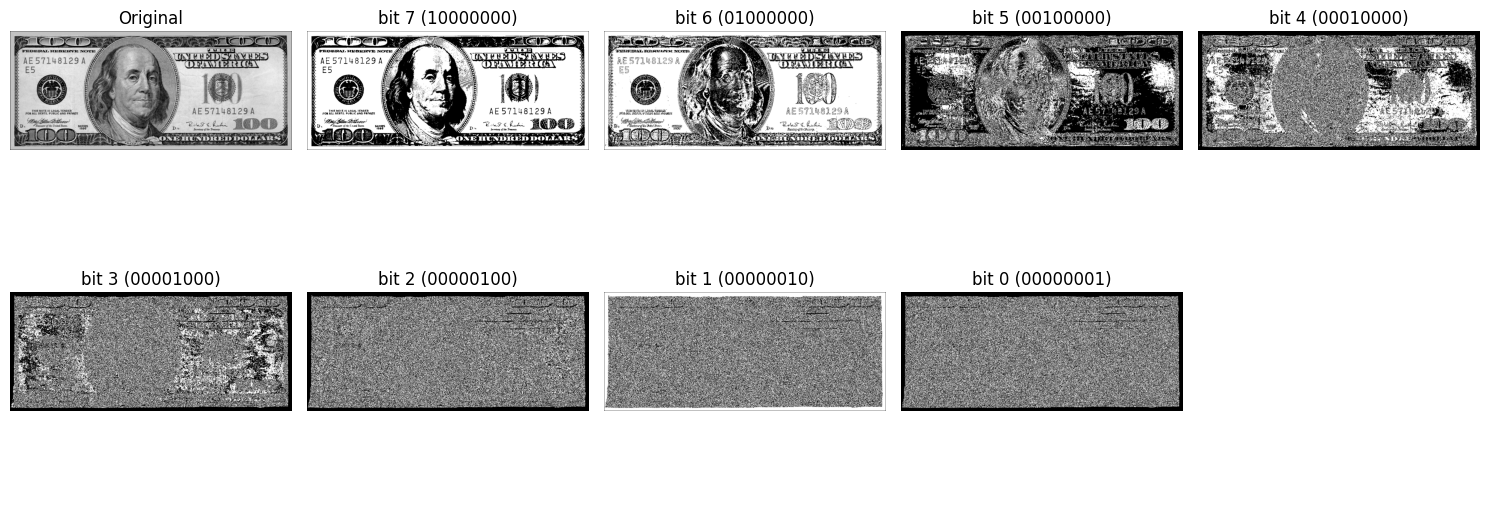

In [104]:
# Bit-Plane Slicing: 10000000 → 00000001
import cv2, numpy as np, matplotlib.pyplot as plt, os

# ---- Helper ----
def ensure_gray_uint8(p):
    im = cv2.imread(p, cv2.IMREAD_UNCHANGED)
    if im is None: raise FileNotFoundError(p)
    if im.ndim == 3: im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return np.clip(im, 0, 255).astype(np.uint8)

# ---- Load ----
path = "input/Fig0314(a)(100-dollars).tif"           # đổi tên nếu khác
img  = ensure_gray_uint8(path)
H, W = img.shape
os.makedirs("output_bitplanes", exist_ok=True)

# ---- Tách 8 bit-planes (MSB→LSB) ----
# bit 7: 10000000, bit 0: 00000001
planes = []
titles = []
for b in range(7, -1, -1):
    mask  = 1 << b
    plane = ((img & mask) >> b) * 255    # đưa về 0/255 để hiển thị
    cv2.imwrite(f"output_bitplanes/bit{b}_{mask:08b}.png", plane)
    planes.append(plane)
    titles.append(f"bit {b} ({mask:08b})")

# ---- Hiển thị: Original + 8 planes (2 hàng) ----
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
# Ảnh gốc
axes[0,0].imshow(img, cmap='gray', vmin=0, vmax=255)
axes[0,0].set_title("Original")
axes[0,0].axis("off")

# Các bit-planes (MSB→LSB)
idx = 1
for p, t in zip(planes, titles):
    r, c = divmod(idx, 5)
    axes[r, c].imshow(p, cmap='gray', vmin=0, vmax=255)
    axes[r, c].set_title(t)
    axes[r, c].axis("off")
    idx += 1

# nếu còn ô trống thì tắt
while idx < 10:
    r, c = divmod(idx, 5)
    axes[r, c].axis("off")
    idx += 1

plt.tight_layout(); plt.show()



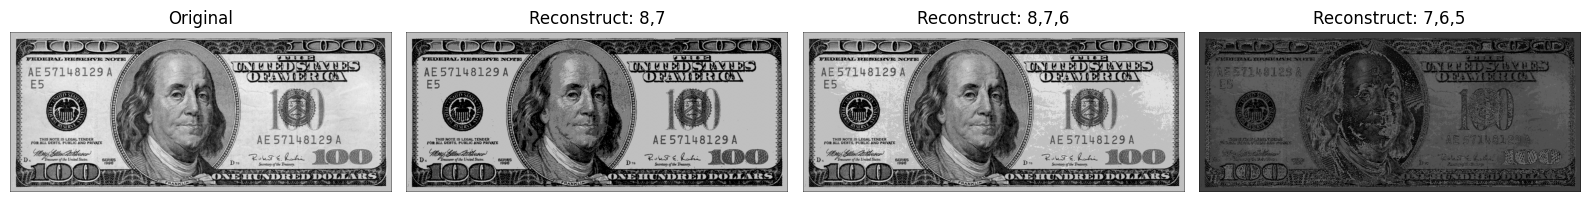

In [105]:
# Reconstruct from selected bit-planes (using "plane 8..1" naming)
import cv2, numpy as np, matplotlib.pyplot as plt, os

def ensure_gray_uint8(p):
    im = cv2.imread(p, cv2.IMREAD_UNCHANGED)
    if im is None: raise FileNotFoundError(p)
    if im.ndim == 3: im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return np.clip(im, 0, 255).astype(np.uint8)

# --- Load the same image ---
path = "input/Fig0314(a)(100-dollars).tif"
img  = ensure_gray_uint8(path)
os.makedirs("output_bitplanes", exist_ok=True)

def reconstruct_from_planes(img_u8, plane_numbers):
    """
    plane_numbers: list các 'mặt' theo cách gọi 8..1 (8 là MSB).
    Ví dụ [8,7] -> bit indices [7,6].
    """
    mask = 0
    for pn in plane_numbers:
        b = pn - 1          # đổi 8..1 -> bit index 7..0
        mask |= (1 << b)
    recon = img_u8 & mask   # giữ nguyên các bit được chọn, còn lại 0
    return recon

# Các tổ hợp cần tái tạo
sets = {
    "planes_8_7":   [8, 7],
    "planes_8_7_6": [8, 7, 6],
    "planes_7_6_5": [7, 6, 5],
}

# Tạo và lưu ảnh tái tạo
recons = {}
for name, planes in sets.items():
    imr = reconstruct_from_planes(img, planes)
    recons[name] = imr
    cv2.imwrite(f"output_bitplanes/recon_{name}.png", imr)

# Hiển thị: Original + 3 bản tái tạo (1 hàng)
fig, axes = plt.subplots(1, 4, figsize=(16, 5))
axes[0].imshow(img, cmap='gray', vmin=0, vmax=255); axes[0].set_title("Original"); axes[0].axis("off")
axes[1].imshow(recons["planes_8_7"],   cmap='gray', vmin=0, vmax=255); axes[1].set_title("Reconstruct: 8,7"); axes[1].axis("off")
axes[2].imshow(recons["planes_8_7_6"], cmap='gray', vmin=0, vmax=255); axes[2].set_title("Reconstruct: 8,7,6"); axes[2].axis("off")
axes[3].imshow(recons["planes_7_6_5"], cmap='gray', vmin=0, vmax=255); axes[3].set_title("Reconstruct: 7,6,5"); axes[3].axis("off")
plt.tight_layout(); plt.show()
